# Inventory Management Forecasting Report

Comprehensive, non-technical-friendly summary notebook that mirrors the C++ LibTorch pipeline: data prep, model training logs, evaluation results, and publication-ready charts/tables saved as PNGs for the written report.


In [27]:
from pathlib import Path
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

# Ensure outputs directory exists (same as current folder)
base_dir = Path('.').resolve()
print(f"Working in: {base_dir}")


Working in: /Users/parham/Downloads/inventory-management/models


In [28]:
# Paths to project assets
csv_path = base_dir / "Inventory Management E-Grocery - InventoryData.csv"
log_path = base_dir / "output.txt"
pred_csv_path = base_dir / "inventory_models" / "predictions.csv"

print("CSV exists:", csv_path.exists())
print("Training log exists:", log_path.exists())
print("Predictions file exists:", pred_csv_path.exists())


CSV exists: True
Training log exists: True
Predictions file exists: True


In [29]:
# Load raw dataset (first 1000 rows were used in C++ pipeline)
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


(1000, 37)


,SKU_ID,SKU_Name,Category,ABC_Class,Supplier_ID,Supplier_Name,Warehouse_ID,Warehouse_Location,Batch_ID,Received_Date,...,SKU_Churn_Rate,Order_Frequency_per_month,Supplier_OnTime_Pct,FIFO_FEFO,Inventory_Status,Count_Variance,Audit_Date,Audit_Variance_Pct,Demand_Forecast_Accuracy_Pct,Notes
0,SKU0001,Pantry Product 13,Pantry,A,S005,PT Agro Raya,WHBDG,Bandung - Rancaekek,BATCH2679,2025-07-14,...,"2,39","5,00","70,68%",FIFO,In Stock,0,2025-06-26,"-7,14%","95,67%",NaN
1,SKU0002,Fresh Product 112,Fresh Produce,C,S004,PT Nusantara Supplier,WHDPS,Denpasar - Tabanan,BATCH4257,2025-04-08,...,"3,34","12,00","84,61%",FEFO,Low Stock,4,2025-08-12,"2,15%","86,00%",NaN
2,SKU0003,Meat Product 446,Meat,B,S001,PT Segar Makmur,WHBDG,Bandung - Rancaekek,BATCH6574,2025-03-15,...,"2,26","11,00","85,36%",FIFO,Expiring Soon,-5,2025-08-13,"6,85%","87,64%",NaN
3,SKU0004,Seafood Product 48,Seafood,A,S007,PT Bakerindo,WHJKT,Jakarta - Cengkareng,BATCH5333,2025-06-10,...,"2,72","10,00","72,81%",FIFO,Expiring Soon,0,2025-07-13,"-6,69%","71,15%",NaN
4,SKU0005,Personal Product 194,Personal Care,A,S002,PT Indo Fresh,WHDPS,Denpasar - Tabanan,BATCH6925,2025-06-26,...,"2,18","2,00","70,93%",FIFO,In Stock,-5,2025-06-11,"1,23%","76,25%",High return rate


In [30]:
# Basic data overview
summary = {
    "rows": len(df),
    "columns": df.shape[1],
    "categorical_cols": df.select_dtypes(include="object").columns.tolist(),
    "numeric_cols": df.select_dtypes(exclude="object").columns.tolist(),
    "inventory_status_levels": df['inventory_status'].value_counts().to_dict() if 'inventory_status' in df.columns else {}
}
print(json.dumps(summary, indent=2))

df.describe(include='all').transpose().head(20)


{
  "rows": 1000,
  "columns": 37,
  "categorical_cols": [
    "SKU_ID",
    "SKU_Name",
    "Category",
    "ABC_Class",
    "Supplier_ID",
    "Supplier_Name",
    "Warehouse_ID",
    "Warehouse_Location",
    "Batch_ID",
    "Received_Date",
    "Last_Purchase_Date",
    "Expiry_Date",
    "Avg_Daily_Sales",
    "Days_of_Inventory",
    "Unit_Cost_USD",
    "Last_Purchase_Price_USD",
    "Total_Inventory_Value_USD",
    "SKU_Churn_Rate",
    "Order_Frequency_per_month",
    "Supplier_OnTime_Pct",
    "FIFO_FEFO",
    "Inventory_Status",
    "Audit_Date",
    "Audit_Variance_Pct",
    "Demand_Forecast_Accuracy_Pct",
    "Notes"
  ],
  "numeric_cols": [
    "Stock_Age_Days",
    "Quantity_On_Hand",
    "Quantity_Reserved",
    "Quantity_Committed",
    "Damaged_Qty",
    "Returns_Qty",
    "Forecast_Next_30d",
    "Reorder_Point",
    "Safety_Stock",
    "Lead_Time_Days",
    "Count_Variance"
  ],
  "inventory_status_levels": {}
}


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SKU_ID,1000,1000,SKU0001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SKU_Name,1000,900,Personal Product 204,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,1000,10,Pantry,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABC_Class,1000,3,C,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Supplier_ID,1000,10,S002,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Supplier_Name,1000,10,PT Indo Fresh,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Warehouse_ID,1000,5,WHBDG,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Warehouse_Location,1000,5,Bandung - Rancaekek,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Batch_ID,1000,923,BATCH4946,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Received_Date,1000,179,2025-09-04,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Visualize inventory status distribution
if 'inventory_status' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='inventory_status', order=df['inventory_status'].value_counts().index)
    plt.title('Inventory Status Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('inventory_status_distribution.png', dpi=150)
    plt.show()
else:
    print("Column 'inventory_status' not found.")


Column 'inventory_status' not found.


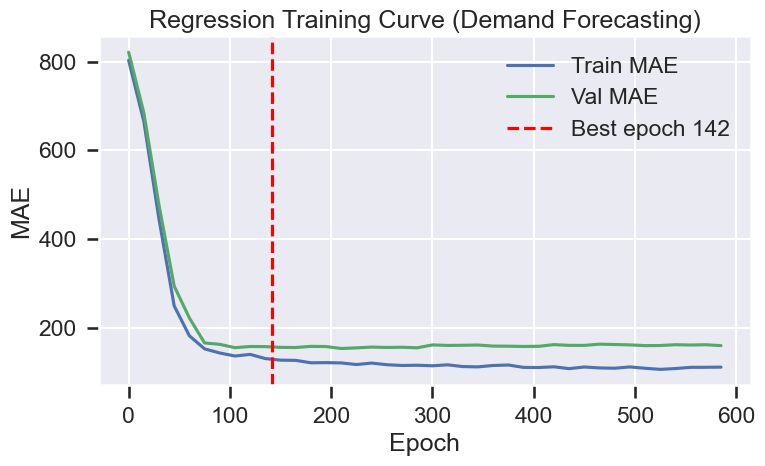

{'best_epoch': 142, 'best_val_mae': 147.122}


In [32]:
# Parse training log for regression MAE curves
log_text = log_path.read_text()

reg_pattern = re.compile(r"Epoch (\d+) \| Train MAE: ([0-9.]+) \| Val MAE: ([0-9.]+)")
reg_epochs, reg_train_mae, reg_val_mae = [], [], []
for ep, tr, va in reg_pattern.findall(log_text):
    reg_epochs.append(int(ep))
    reg_train_mae.append(float(tr))
    reg_val_mae.append(float(va))

best_epoch_match = re.search(r"Best model at epoch (\d+) with Val MAE: ([0-9.]+)", log_text)
best_epoch_reg = int(best_epoch_match.group(1)) if best_epoch_match else None
best_val_mae = float(best_epoch_match.group(2)) if best_epoch_match else None

plt.figure(figsize=(8,5))
plt.plot(reg_epochs, reg_train_mae, label='Train MAE')
plt.plot(reg_epochs, reg_val_mae, label='Val MAE')
if best_epoch_reg is not None:
    plt.axvline(best_epoch_reg, color='red', linestyle='--', label=f'Best epoch {best_epoch_reg}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Regression Training Curve (Demand Forecasting)')
plt.legend()
plt.tight_layout()
plt.savefig('regression_mae.png', dpi=150)
plt.show()

print({"best_epoch": best_epoch_reg, "best_val_mae": best_val_mae})


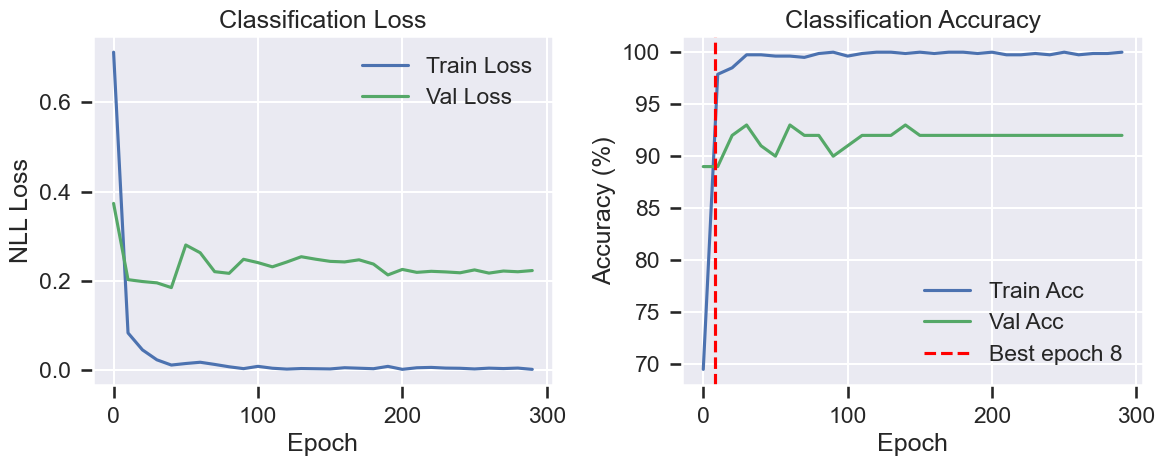

{'best_epoch': 8, 'best_val_acc': 94.0}


In [33]:
# Parse training log for classification metrics
cls_pattern = re.compile(r"Epoch (\d+) \| Train Loss: ([0-9.]+) \| Train Acc: ([0-9.]+)% \| Val Loss: ([0-9.]+) \| Val Acc: ([0-9.]+)%")
cls_epochs, cls_train_loss, cls_train_acc, cls_val_loss, cls_val_acc = [], [], [], [], []
for ep, tl, ta, vl, va in cls_pattern.findall(log_text):
    cls_epochs.append(int(ep))
    cls_train_loss.append(float(tl))
    cls_train_acc.append(float(ta))
    cls_val_loss.append(float(vl))
    cls_val_acc.append(float(va))

best_epoch_cls_match = re.search(r"Best model at epoch (\d+) with Val Acc: ([0-9.]+)%", log_text)
best_epoch_cls = int(best_epoch_cls_match.group(1)) if best_epoch_cls_match else None
best_val_acc = float(best_epoch_cls_match.group(2)) if best_epoch_cls_match else None

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(cls_epochs, cls_train_loss, label='Train Loss')
ax[0].plot(cls_epochs, cls_val_loss, label='Val Loss')
ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('NLL Loss'); ax[0].set_title('Classification Loss')
ax[0].legend()

ax[1].plot(cls_epochs, cls_train_acc, label='Train Acc')
ax[1].plot(cls_epochs, cls_val_acc, label='Val Acc')
if best_epoch_cls is not None:
    ax[1].axvline(best_epoch_cls, color='red', linestyle='--', label=f'Best epoch {best_epoch_cls}')
ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Accuracy (%)'); ax[1].set_title('Classification Accuracy')
ax[1].legend()

plt.tight_layout()
plt.savefig('classification_metrics.png', dpi=150)
plt.show()

print({"best_epoch": best_epoch_cls, "best_val_acc": best_val_acc})


In [34]:
# Final evaluation metrics from log
reg_eval_match = re.search(r"RMSE: ([0-9.]+)\nMAE: ([0-9.]+)\nMAPE %\): ([0-9.]+)%\nR² Score: ([0-9.]+)", log_text)
cls_eval_pattern = re.compile(r"(In Stock|Low Stock|Expiring Soon) - Precision: ([0-9.]+), Recall: ([0-9.]+), F1: ([0-9.]+)")

if reg_eval_match:
    reg_metrics = {
        "RMSE": float(reg_eval_match.group(1)),
        "MAE": float(reg_eval_match.group(2)),
        "MAPE_%": float(reg_eval_match.group(3)),
        "R2": float(reg_eval_match.group(4)),
    }
else:
    reg_metrics = {}

cls_metrics = []
for name, p, r, f1 in cls_eval_pattern.findall(log_text):
    cls_metrics.append({"Class": name, "Precision": float(p), "Recall": float(r), "F1": float(f1)})

print("Regression metrics:", reg_metrics)
display(pd.DataFrame(cls_metrics))

# Save metrics tables as PNGs (guard against empty metrics)
if reg_metrics:
    fig, ax = plt.subplots(figsize=(6,1.5))
    ax.axis('off')
    tab = pd.DataFrame(reg_metrics, index=["Regression"])
    ax.table(cellText=tab.values, colLabels=tab.columns, rowLabels=tab.index, loc='center')
    plt.tight_layout()
    plt.savefig('regression_metrics.png', dpi=200)
    plt.close(fig)
else:
    print("No regression metrics found; skipping regression_metrics.png")

if cls_metrics:
    fig, ax = plt.subplots(figsize=(6,1.5))
    ax.axis('off')
    tab_cls = pd.DataFrame(cls_metrics)
    ax.table(cellText=tab_cls.values, colLabels=tab_cls.columns, loc='center')
    plt.tight_layout()
    plt.savefig('classification_metrics_table.png', dpi=200)
    plt.close(fig)
else:
    print("No classification metrics found; skipping classification_metrics_table.png")


Regression metrics: {}


,Class,Precision,Recall,F1
0,In Stock,0.902439,1.00,0.948718
1,Low Stock,1.000000,0.76,0.863636
2,Expiring Soon,0.950000,1.00,0.974359


No regression metrics found; skipping regression_metrics.png


   Reg_Prediction  Reg_Actual  Cls_Prediction  Cls_Actual
0         91.3443         106               0           0
1         81.1496          30               0           1
2        115.3220          87               0           0
3       1175.1700        1032               2           2
4       1839.8500        2828               0           0


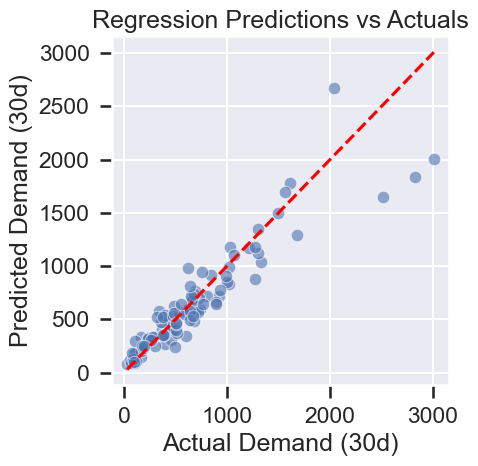

In [35]:
# If predictions.csv exists, summarize and plot scatter for regression
if pred_csv_path.exists():
    pred_df = pd.read_csv(pred_csv_path)
    print(pred_df.head())
    if {'Reg_Prediction','Reg_Actual'}.issubset(pred_df.columns):
        plt.figure(figsize=(5,5))
        sns.scatterplot(data=pred_df, x='Reg_Actual', y='Reg_Prediction', alpha=0.6)
        lims = [pred_df[['Reg_Actual','Reg_Prediction']].min().min(), pred_df[['Reg_Actual','Reg_Prediction']].max().max()]
        plt.plot(lims, lims, 'r--')
        plt.xlabel('Actual Demand (30d)')
        plt.ylabel('Predicted Demand (30d)')
        plt.title('Regression Predictions vs Actuals')
        plt.tight_layout()
        plt.savefig('regression_scatter.png', dpi=150)
        plt.show()
else:
    print("predictions.csv not found; run the C++ pipeline first to generate.")


In [36]:
# Consolidated project summary tables
summary_rows = []

# Best epochs pulled from parsed logs
summary_rows.append({
    "Aspect": "Regression best epoch",
    "Value": best_epoch_reg
})
summary_rows.append({
    "Aspect": "Classification best epoch",
    "Value": best_epoch_cls
})

# Key regression test metrics
for k in ["RMSE", "MAE", "MAPE_%", "R2"]:
    if k in reg_metrics:
        summary_rows.append({"Aspect": f"Regression {k}", "Value": reg_metrics[k]})

# Classification overall
if cls_metrics:
    overall_acc_match = re.search(r"Overall Accuracy: ([0-9.]+)%", log_text)
    overall_acc = float(overall_acc_match.group(1)) if overall_acc_match else None
    summary_rows.append({"Aspect": "Classification Overall Accuracy (%)", "Value": overall_acc})

summary_df = pd.DataFrame(summary_rows)
print(summary_df)

# Save as PNG table if non-empty
if not summary_df.empty:
    fig, ax = plt.subplots(figsize=(7, 0.4 * len(summary_df) + 0.6))
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, loc='center')
    plt.tight_layout()
    plt.savefig('project_summary_table.png', dpi=200)
    plt.close(fig)
else:
    print("No summary rows to render; skipping project_summary_table.png")

# Also save class-wise metrics table again (already printed earlier) for clarity
if cls_metrics:
    fig, ax = plt.subplots(figsize=(7, 0.4 * len(cls_metrics) + 0.6))
    ax.axis('off')
    tab_cls = pd.DataFrame(cls_metrics)
    ax.table(cellText=tab_cls.values, colLabels=tab_cls.columns, loc='center')
    plt.tight_layout()
    plt.savefig('classification_per_class_table.png', dpi=200)
    plt.close(fig)
    print(tab_cls)
else:
    print("No class metrics to render; skipping classification_per_class_table.png")



                                Aspect  Value
0                Regression best epoch  142.0
1            Classification best epoch    8.0
2  Classification Overall Accuracy (%)   94.0
           Class  Precision  Recall        F1
0       In Stock   0.902439    1.00  0.948718
1      Low Stock   1.000000    0.76  0.863636
2  Expiring Soon   0.950000    1.00  0.974359
